In [1]:
!pip install numpyro dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00


In [2]:
import pickle
import os
import torch

import numpy as np
import geopandas as gpd
import jax
import jax.numpy as jnp
from jax import random
from jax import random, lax, jit, ops
from jax.example_libraries import stax

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import dill

import time

In [3]:
#ensure this script runs on GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Script B running on {device}")

Script B running on cpu


In [4]:
#define the necessary functions
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)

def vae_decoder(hidden_dim, out_dim):
    return stax.serial(
        # (num_samples, z_dim) -> (num_samples, hidden_dim): (5,40) -> (5,50)
        stax.Dense(hidden_dim, W_init = stax.randn()),
        stax.Elu,
        # (num_samples, hidden_dim) -> (num_samples, num_regions) : (5,50) -> (5, 58)
        stax.Dense(out_dim, W_init = stax.randn())
    )

In [5]:
def prev_model_vae_aggr(args):

    x = args["x"]
    out_dims = args["out_dims"]
    pop_density = args["pop_density"]
    hdi = args["hdi"]
    total_cases = args["total_cases"]
    total_population = args["total_population"]
    n = args["sigma"]

    # random effect
    decoder_params =args["decoder_params"]
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    _, decoder_apply = vae_decoder(hidden_dim, out_dims) #Instantiate decoder
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_apply(decoder_params, z))
    s = numpyro.sample("sigma", dist.HalfNormal(n))
    vae = numpyro.deterministic("vae", s * vae_aggr)

    ## Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  #Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  #Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  #Effect of HDI

    #scale pop_density and hdi (normalise)
    # Standardize covariates
    pop_density = (pop_density - jnp.mean(pop_density)) / (jnp.std(pop_density))
    hdi = (hdi - jnp.mean(hdi)) / (jnp.std(hdi))

    # Linear predictor
    lp = b0 + vae + b_pop_density * pop_density + b_hdi * hdi  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp)*1e-2)  # (num_districts,)

    # Binomial likelihood
    observed_cases = numpyro.sample(
        "observed_cases",
        dist.Binomial(total_count=total_population, probs = theta),
        obs=total_cases
    )

##Load variables

In [6]:
# Lat/Lon Values of artificial grid
x = np.load("lat_lon_x_all.npy")

# combined regional data
pol_pts_all = np.load("pol_pts_all.npy")
pt_which_pol_all = np.load("pt_which_pol_all.npy")

#combine the dataframes
df_combined = gpd.read_file("final_combined_divisions.shp")

In [7]:
#hidden dim of vae
h = 50

#z dim of vae
a = 20

##Vars that need to be changed (??)

In [8]:
M = pol_pts_all
out_dims = df_combined.shape[0]

##Arguments to Model

In [9]:
args = {
        "total_cases" : jnp.array(df_combined["Cases"]),
        "total_population" : jnp.array(df_combined["Population"]),
        "hdi" : jnp.array(df_combined["HDI"]),
        "pop_density" : jnp.array(df_combined["Pop_den"]),
        "x" : jnp.array(x),
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M" : M,
        # VAE training
        "rng_key": random.PRNGKey(5),
        "num_epochs": 20,
        "learning_rate": 0.0005,
        "batch_size": 100,
        "out_dims" : out_dims,
        "num_train": 100,
        "num_test":100,
        "vae_var": 1,
        "sigma": 50
    }

##Load decoder model

In [11]:
#change the specific file name under the folder model_weights
with open("aggVAE_e20_h50_z20", "rb") as file:
        vae_params = pickle.load(file)

encoder_params = vae_params["encoder$params"]
decoder_params = vae_params["decoder$params"]
args["decoder_params"] = decoder_params

##Run MCMC (ask prof abt the warmup and the samples too)

In [12]:
# Get script location and define correct save directory (sibling to src/)
script_dir = os.getcwd()  # Get current working directory
save_dir = os.path.abspath(os.path.join(script_dir, "..", "model_weights", "aggVAEPrev"))  # Move up and into model_weights
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

#set seed for running mcmc
mcmc_key, predict_key = random.split(random.PRNGKey(0))
start_time = time.time()
mcmc = MCMC(NUTS(prev_model_vae_aggr), num_warmup = 1000, num_samples = 2000, num_chains = 4)

mcmc.run(mcmc_key, args)
t_elapsed = time.time() - start_time
t_elapsed_mins = int(t_elapsed / 60)

mcmc.print_summary(exclude_deterministic = False)

<ipython-input-12-5fe9d1121c00>:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(prev_model_vae_aggr), num_warmup = 1000, num_samples = 2000, num_chains = 4)
sample: 100%|██████████| 3000/3000 [00:53<00:00, 56.11it/s, 1023 steps of size 5.52e-03. acc. prob=0.93]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -1.87      0.15     -1.95     -1.98     -1.60      2.02      8.91
          b_hdi      0.00      0.02      0.01     -0.04      0.03      2.42      2.28
  b_pop_density     -0.44      0.02     -0.43     -0.48     -0.42      2.09      4.45
          sigma     78.55     17.59     87.93     47.18     91.07      2.01     11.87
       theta[0]      0.00      0.00      0.00      0.00      0.00      2.04      6.74
       theta[1]      0.00      0.00      0.00      0.00      0.00      2.02      9.55
       theta[2]      0.00      0.00      0.00      0.00      0.00      2.01     12.35
       theta[3]      0.00      0.00      0.00      0.00      0.00      2.06      5.44
       theta[4]      0.00      0.00      0.00      0.00      0.00      2.07      5.21
       theta[5]      0.00      0.00      0.00      0.00      0.00      2.03      8.13
       theta[6]      0.00      0.00      0.00      0.

In [13]:
n_samples = 2000
n_warmup = 1000
n = args["sigma"]

#save the mcmc
# Specify the save directory in Colab's local environment
save_dir = "/content"  # You can save directly to /content, or specify a subfolder
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Define the file path
f_path = os.path.join(save_dir, f"aggVAEPrev_nsamples_{n_samples}_tt{t_elapsed_mins}min_sigma{n}_hdim{h}_zdim{a}.pkl")

# Save the MCMC object using dill
with open(f_path, "wb") as file:
    dill.dump(mcmc, file)

print(f"Saved aggVAEPrev MCMC samples to {f_path}")

Saved aggVAEPrev MCMC samples to /content/aggVAEPrev_nsamples_2000_tt3min_sigma50_hdim50_zdim20.pkl


In [14]:
#print total elapsed time
total_end = time.time()
print("\nMCMC Total elapsed time:", round(total_end), "s")
print("MCMC Total elapsed time:", round(total_end / 60), "min")
print("MCMC Total elapsed time:", round(total_end / (60 * 60)), "h")


MCMC Total elapsed time: 1743426592 s
MCMC Total elapsed time: 29057110 min
MCMC Total elapsed time: 484285 h


In [15]:
#print the summary stats
combined_samples = mcmc.get_samples(group_by_chain = True)
mcmc.print_summary(exclude_deterministic=False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -1.87      0.15     -1.95     -1.98     -1.60      2.02      8.91
          b_hdi      0.00      0.02      0.01     -0.04      0.03      2.42      2.28
  b_pop_density     -0.44      0.02     -0.43     -0.48     -0.42      2.09      4.45
          sigma     78.55     17.59     87.93     47.18     91.07      2.01     11.87
       theta[0]      0.00      0.00      0.00      0.00      0.00      2.04      6.74
       theta[1]      0.00      0.00      0.00      0.00      0.00      2.02      9.55
       theta[2]      0.00      0.00      0.00      0.00      0.00      2.01     12.35
       theta[3]      0.00      0.00      0.00      0.00      0.00      2.06      5.44
       theta[4]      0.00      0.00      0.00      0.00      0.00      2.07      5.21
       theta[5]      0.00      0.00      0.00      0.00      0.00      2.03      8.13
       theta[6]      0.00      0.00      0.00      0.

In [16]:
#metric values (ESS and Rhat)
# Compute ESS and R-hat diagnostics
ss = numpyro.diagnostics.summary(combined_samples)

# Debugging: Print available keys
print("Available keys in ss:", ss.keys())

# Compute and print diagnostics
r = np.mean(ss["vae_aggr"]["n_eff"])
print(f"Average ESS for all aggVAE effects for {n_samples} samples: {round(r)}")
print(f"Max R-hat for all aggVAE effects for {n_samples} samples: {round(np.max(ss['vae_aggr']['r_hat']), 2)}")

Available keys in ss: dict_keys(['b0', 'b_hdi', 'b_pop_density', 'sigma', 'theta', 'vae', 'vae_aggr', 'z'])
Average ESS for all aggVAE effects for 2000 samples: 2
Max R-hat for all aggVAE effects for 2000 samples: 31.68000030517578


In [17]:
# Extract posterior samples from VAE aggregation
theta_samps_vae_aggr = combined_samples["theta"]
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=(0, 1))
bci_vae_aggr_25 = np.quantile(theta_samps_vae_aggr, 0.25, axis=(0, 1))
bci_vae_aggr_75 = np.quantile(theta_samps_vae_aggr, 0.75, axis=(0, 1))

In [18]:
# Ensure theta estimates are correctly assigned to DataFrame
df_combined["theta_vae"] = theta_mean_vae_aggr[: df_combined.shape[0]]

In [19]:
# Observed prevalence
df_combined["obs_prev"] = df_combined.Cases / df_combined.Population
theta_observed = df_combined["obs_prev"]

In [20]:
# Ensure theta_observed and theta_mean_vae_aggr are properly shaped
theta_observed = np.squeeze(theta_observed)
theta_mean_vae_aggr = np.squeeze(theta_mean_vae_aggr)

In [21]:
# Compute min/max ensuring shape consistency
_max = np.max([theta_observed, theta_mean_vae_aggr])
_min = np.min([theta_observed, theta_mean_vae_aggr])

In [22]:
print("theta_observed shape:", theta_observed.shape)
print("theta_mean_vae_aggr shape:", theta_mean_vae_aggr.shape)

theta_observed shape: (96,)
theta_mean_vae_aggr shape: (96,)


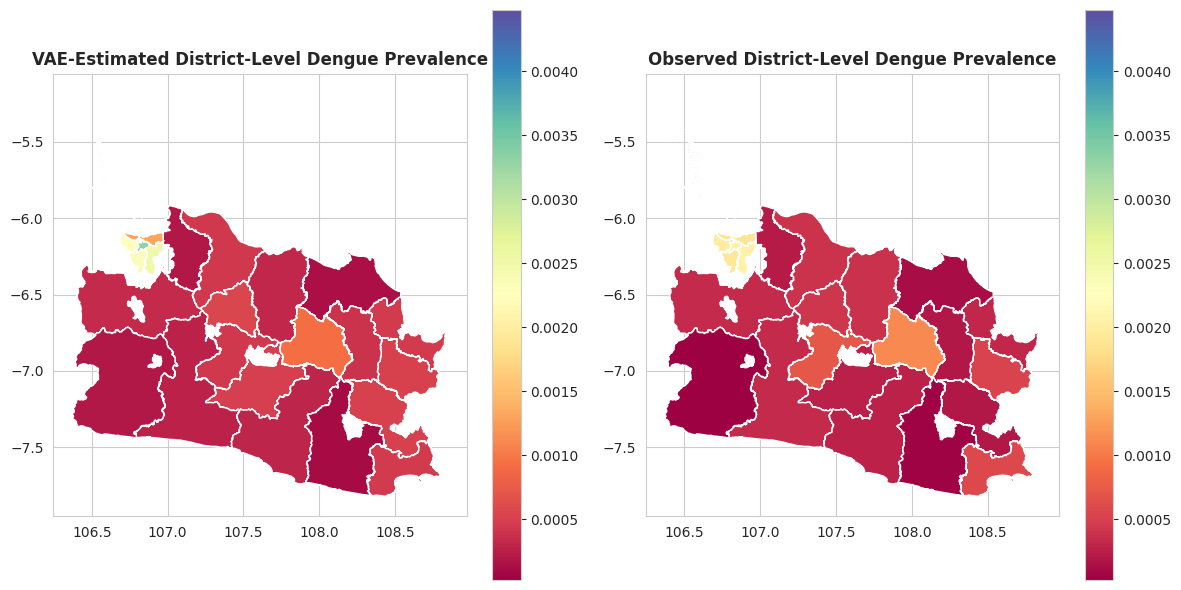

Plot saved to ../plots/vae_vs_observed_prevalence_sigma50_vae_hiddendim_50_zdim_20.png


In [23]:
#plot the observed prevalence vs vae-estimated prevalence
# Set Seaborn style for better visualization
sns.set_style("whitegrid")

# Define a more contrasting color scheme (Spectral has strong contrast)
cmap_choice = "Spectral"  # Try 'coolwarm', 'viridis', 'RdYlBu', or 'Spectral' for better distinction

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot using a high-contrast colormap
df_combined.plot(column="theta_vae", ax=ax[0], legend=True, cmap=cmap_choice, vmin=_min, vmax=_max)
df_combined.plot(column="obs_prev", ax=ax[1], legend=True, cmap=cmap_choice, vmin=_min, vmax=_max)

ax[0].set_title("VAE-Estimated District-Level Dengue Prevalence", fontsize=12, fontweight="bold")
ax[1].set_title("Observed District-Level Dengue Prevalence", fontsize=12, fontweight="bold")

# Improve spacing
plt.tight_layout()

# Save the plot
plot_dir = "../plots"  # Adjust based on directory structure
os.makedirs(plot_dir, exist_ok=True)

# Define the filename
filename = f"{plot_dir}/vae_vs_observed_prevalence_sigma{n}_vae_hiddendim_{h}_zdim_{a}.png"

plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution

# Show the plot (optional)
plt.show()

print(f"Plot saved to {filename}")

In [25]:
#save the df
df_combined.to_csv("df_with_aggVAE_predictions.csv")
df_combined.to_file("df_with_aggVAE_predictions.shp")